In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/BIO_LEZIONI/

/content/drive/MyDrive/BIO_LEZIONI


In [ ]:
#Package import
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import PIL
import copy
import csv
from tqdm import tqdm
from skimage import io, color, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from sklearn.metrics import f1_score

In [ ]:
# Helper function per visuallizare immagine/maschera per controllare l'overlap.
def image_viewer(output_classes, image, mask):

    x=mask[0].numpy()
    x*=output_classes # The function need the classes to be integer
    io.imshow(color.label2rgb(x, image[0].numpy(), bg_label=0)) # Set bkg transparent and shows only
                                                                #  other classes on top of the input png
plt.show()

In [ ]:
# Dataset class loading input images and from two separate folders in numeric order.
class SpineDataset(Dataset):

    def __init__(self, image_dir, mask_dir, output_classes, transform = None):
        self.image_dir = image_dir # Prendofolder delle immagini
        self.mask_dir = mask_dir  # Prendo folder delle maschere
        self.transform = transform # Applico trasformazioni se presenti
        self.output_classes = output_classes
    def __len__(self):
        return len(glob.glob(os.path.join(self.image_dir,'*.png'))) # Numero delle immagini nel folder

    def __getitem__(self,idx):
        img_name = os.path.join(self.image_dir,'%d.png'%idx) # Formato immagini .png
        mask_name = os.path.join(self.mask_dir,'%d.npy'%idx) # Formato maschere .npy
        pil_image = PIL.Image.open(img_name).convert('RGB') # Rete vuole input a 3 canali
        img = np.array(pil_image)
        mask=np.load(mask_name).astype(np.uint8)
        tmp=np.ndarray((mask.shape[0],mask.shape[1],self.output_classes),dtype=np.uint8) # NN expect 3 channel input
        for i in range(self.output_classes):
            tmp[:,:,i]=mask

        sample = {'image': img, 'mask': tmp} # matched image and mask

        if self.transform:
            sample=self.transform(sample) # Su coppia {img,mask} stessa trasformazione

        return sample


In [ ]:
# Funzione di resize immagini che agisce su immagini e maschere coerentemente
class Resize(object):

    def __init__(self, out_dim):
        assert isinstance(out_dim, (int, tuple)) # Accepting both one int or a tuple for scale H, W
        self.out_dim = out_dim

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']
        H, W = img.shape[:2]

        if isinstance(self.out_dim, int):
            if H > W:
                H_out, W_out = self.out_dim * H/ W, self.out_dim
            else:
                H_out, W_out = self.out_dim, self.out_dim * W/ H
        else:
            H_out, W_out = self.out_dim

        H_out, W_out = int(H_out), int(W_out)
        img = transform.resize(img, (H_out, W_out))
        mask = transform.resize(mask, (H_out, W_out))
        return {'image': img, 'mask': mask}

In [ ]:
# Funzione per trasformare dati in inputi in tensori con dimensione Nc, H, W
class ToTensor(object):

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']
        if img.ndim == 3:
            mask = mask.transpose((2, 0, 1))
        if img.ndim == 3:
            img = img.transpose((2, 0, 1))
        return {'image': torch.from_numpy(img).type(torch.FloatTensor), # Tipo desiderato FloatTensor
                'mask': torch.from_numpy(mask).type(torch.FloatTensor)} # Solo se voglio normalizzare maschera

In [ ]:
# Normalizzazione dell'input per avere immagini e maschere in [0,1]
class Normalize(object):

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']
        return {'image': img/255,
                'mask': mask/(mask.shape[2]-1)}

In [ ]:
'''
Il modello predefinito è già configurato con un numero limitato di immagini,
opto per congelare il modello nella fase iniziale, credendo che possa svolgere il compito in modo generale.
Implemento la retropropagazione solo nella fase finale per adattare il modello al mio compito più specializzato.

TLDR: cambio i filtri di convoluzione nell'ultima parte, do' piccolo hint al modello di come svolgere il mio task
'''
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Load. of pretrained model and change of last layer to match the number of classes to be predicted
# Newly added layer will be trained
def createModel(output_classes):
    my_model = models.segmentation.fcn_resnet101(pretrained=True) # prendo modello resnet101 con pesi già inizializzati
    set_parameter_requires_grad(my_model, feature_extracting= True)
    my_model.classifier[4] = nn.Conv2d(512, output_classes, kernel_size=(1, 1), stride=(1, 1)) # sostituisco il quarto layer di classificazione con uno convoluzionale
    my_model.aux_classifier[4] = nn.Conv2d(256, output_classes, kernel_size=(1, 1), stride=(1, 1))
    my_model.train()
    return my_model

In [ ]:
# Function for model training
def train_model(model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs):

    best_model_wts = copy.deepcopy(model.state_dict()) #copia per prendere il miglior modello
    best_loss = 1e10

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use gpu if available
    model.to(device)

    # Logger
    fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Val_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    # Loop epoche
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                dataloaders=dataloader # Select dataset for training
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders=dataloader1 #Select dataste for validation

            # Iterate over data.
            for sample in tqdm(iter(dataloaders)):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0, average='weighted'))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Val' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# Helper function for model semantic segmentation output
def decode_segmap(image, nc=3):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=disc, 2=vertebrae,
               (0, 255, 0), (0, 0, 255)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
def main():
    output_classes = 3
    #dataset and loader
    transformed_dataset_train = SpineDataset(image_dir = 'images/images/', mask_dir = 'images/masks/', output_classes = output_classes,
                                           transform = transforms.Compose([
                                            Normalize(),
                                            ToTensor()
                                ]))
    transformed_dataset_val = SpineDataset(image_dir = 'images/images_val/', mask_dir = 'images/masks_val/', output_classes = output_classes,
                                           transform = transforms.Compose([
                                            Normalize(),
                                            ToTensor()
                                ]))

    # Visual evaluation of correct alignement between image and mask
    fig = plt.figure()

    for i in range(len(transformed_dataset_train)):
        sample = transformed_dataset_train[i]

        print(i, sample['image'].shape, sample['mask'].shape)

        ax = plt.subplot(1, len(transformed_dataset_train)%5, i + 1)

        ax.axis('off')
        image_viewer(output_classes, **sample)

        if i == (len(transformed_dataset_train)%5)-1:
            plt.show()
            break

    dataloader = DataLoader(transformed_dataset_train, batch_size = 4, shuffle = True)
    dataloader1 = DataLoader(transformed_dataset_val, batch_size=2,
                        shuffle=False)

    # Model creation and criterion, optimizer and metric
    my_model = createModel(output_classes)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)
    metrics = {'f1_score': f1_score}
    bpath = 'images'
    # Model training
    my_model_trained=train_model(my_model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs=5)

    # Getting first batch of the training data to run the model and see its performance
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
        break

    # Visualization of the model output on one example image from training
    out = my_model_trained(sample_batched['image'])['out']
    om = torch.argmax(out[0],dim=0).numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.show()



0 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
1 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


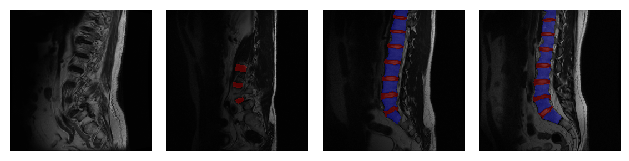

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------


100%|██████████| 4/4 [00:33<00:00,  8.39s/it]


Train Loss: 0.0481


100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


Val Loss: 0.0697
{'epoch': 1, 'Train_loss': 0.04808858409523964, 'Val_loss': 0.06969447433948517, 'Train_f1_score': 0.4955855582829101, 'Val_f1_score': 0.3939642754391393}
Epoch 2/5
----------


100%|██████████| 4/4 [00:32<00:00,  8.21s/it]


Train Loss: 0.0380


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


Val Loss: 0.0682
{'epoch': 2, 'Train_loss': 0.037959322333335876, 'Val_loss': 0.06822662800550461, 'Train_f1_score': 0.3158010080191223, 'Val_f1_score': 0.36185408591048307}
Epoch 3/5
----------


100%|██████████| 4/4 [00:32<00:00,  8.23s/it]


Train Loss: 0.0284


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


Val Loss: 0.0718
{'epoch': 3, 'Train_loss': 0.028428463265299797, 'Val_loss': 0.0718122348189354, 'Train_f1_score': 0.3976668904822521, 'Val_f1_score': 0.5553682736605828}
Epoch 4/5
----------


100%|██████████| 4/4 [00:33<00:00,  8.29s/it]


Train Loss: 0.0277


100%|██████████| 3/3 [00:13<00:00,  4.39s/it]


Val Loss: 0.0669
{'epoch': 4, 'Train_loss': 0.0277368426322937, 'Val_loss': 0.06693617254495621, 'Train_f1_score': 0.5213535462961891, 'Val_f1_score': 0.46055956380872387}
Epoch 5/5
----------


100%|██████████| 4/4 [00:35<00:00,  8.77s/it]


Train Loss: 0.0555


100%|██████████| 3/3 [00:12<00:00,  4.28s/it]


Val Loss: 0.0679
{'epoch': 5, 'Train_loss': 0.055547118186950684, 'Val_loss': 0.06787341088056564, 'Train_f1_score': 0.4429871873103114, 'Val_f1_score': 0.4037212144850731}
0 torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


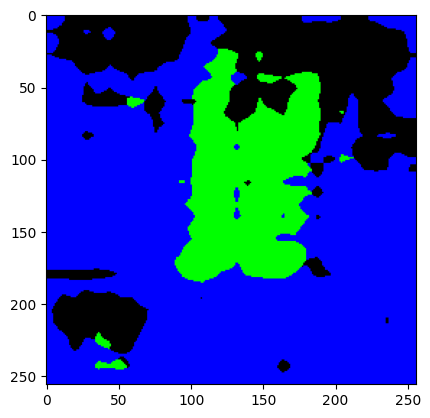

In [ ]:
main()